# 01 — Data Inspection

The SocratiQ dataset (Ang et al., EACL 2023) consists of approximately 110,000 (context, question) pairs collected from Reddit's r/changemyview, where each context is a user-submitted opinion and each question is a human-authored Socratic prompt. A distinguishing property of the dataset is that questions are designed to be *unanswerable from the context alone* — they require external knowledge or reflection that the context does not supply. This makes the generation task genuinely non-trivial and differentiates it from extractive question-generation benchmarks.

This notebook documents the dataset's split sizes, column structure, question-type distribution, and input/output length statistics. These observations directly inform the preprocessing choices made in notebook 02.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

The dataset is sourced from the SocratiQ repository (Ang et al., EACL 2023) and should be cloned to `datasets/raw/soqg/`. The three training chunks are concatenated to form the full 84,582-example training split.

In [16]:
!git clone https://github.com/NUS-IDS/eacl23_soqg.git ../datasets/raw/soqg

Cloning into '../datasets/raw/soqg'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 254 (delta 31), reused 114 (delta 30), pack-reused 136 (from 1)
Receiving objects: 100% (254/254), 40.70 MiB | 3.03 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [17]:
DATA_DIR = Path("../datasets/raw/soqg/data/soqg_dataset")

TRAIN_FILES = [
    "train_chunk_I.csv",
    "train_chunk_II.csv",
    "train_chunk_III.csv"
]
VALID_FILE = "valid.csv"
TEST_FILE = "test.csv"

In [ ]:
train_chunks = []
for f in TRAIN_FILES:
    filepath = DATA_DIR / f
    if filepath.exists():
        chunk = pd.read_csv(filepath, index_col=0)
        train_chunks.append(chunk)
        print(f"Loaded {f}: {len(chunk)} rows")
    else:
        print(f"Warning: {f} not found at {filepath}")

train_df = pd.concat(train_chunks, axis=0, ignore_index=True)
print(f"\nTotal training samples: {len(train_df)}")

In [19]:
valid_path = DATA_DIR / VALID_FILE
test_path = DATA_DIR / TEST_FILE

valid_df = pd.read_csv(valid_path, index_col=0) if valid_path.exists() else pd.DataFrame()
test_df = pd.read_csv(test_path, index_col=0) if test_path.exists() else pd.DataFrame()

print(f"Validation samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")

Validation samples: 10573
Test samples: 10573


In [20]:
print("Columns:", train_df.columns.tolist())
print("\nData types:")
print(train_df.dtypes)

Columns: ['input', 'target']

Data types:
input     object
target    object
dtype: object


Each row in the dataset has two fields. The `input` column contains the question-type prefix followed by a colon and the opinion text (e.g., `reasons_evidence: I believe...`). The `target` column contains the Socratic question to be generated.

In [22]:
print("Sample Input (Context):")
print("-" * 50)
print(train_df.iloc[0]['input'][:500])
print("\n")
print("Sample Target (Socratic Question):")
print("-" * 50)
print(train_df.iloc[0]['target'])

Sample Input (Context):
--------------------------------------------------
alternate_viewpoints_perspectives: A parallel argument would state that England is worse off because America passed them as the dominant economic power in the world. Is the argument remotely true? Not at all - England has become far wealthier from trade with America. I'm typing this reply on a Samsung phone, made in Korea, which was an undeveloped country in the not too distant past. Who knows, maybe Vietnam has some kids now who will figure out a better smartphone. I'd love it if they became we


Sample Target (Socratic Question):
--------------------------------------------------
What about nations who have nothing?


## Question Types

The SocratiQ dataset encodes five rhetorical categories derived from Paul & Elder's (2006) critical thinking taxonomy: *clarification*, *probing assumptions*, *reasons and evidence*, *implications and consequences*, and *alternative viewpoints and perspectives*. The category prefix is prepended to each input example during preprocessing as a conditioning signal for the decoder.

In [9]:
def extract_question_type(input_text):
    if ':' in input_text:
        return input_text.split(':')[0].strip().lower()
    return 'unknown'

train_df['question_type'] = train_df['input'].apply(extract_question_type)
valid_df['question_type'] = valid_df['input'].apply(extract_question_type)
test_df['question_type'] = test_df['input'].apply(extract_question_type)

print("Question types found:")
print(train_df['question_type'].value_counts())

Question types found:
question_type
reasons_evidence                     29797
clarity                              29327
implication_consequences             18789
alternate_viewpoints_perspectives     5946
assumptions                            723
Name: count, dtype: int64


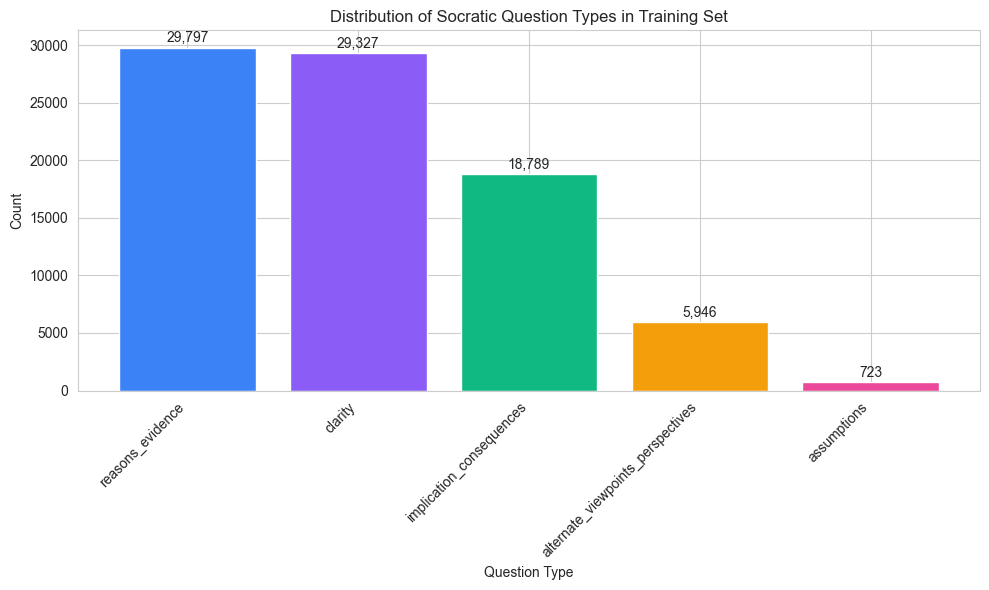

In [20]:
type_counts = train_df['question_type'].value_counts()
colors = ['#3B82F6', '#8B5CF6', '#10B981', '#F59E0B', '#EC4899']

plt.figure(figsize=(10, 6))
bars = plt.bar(type_counts.index.tolist(), type_counts.values.tolist(), color=colors[:len(type_counts)])
plt.xlabel('Question Type')
plt.ylabel('Count')
plt.title('Distribution of Socratic Question Types in Training Set')
plt.xticks(rotation=45, ha='right')

for bar, count in zip(bars, type_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, 
             f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [11]:
print("Missing values:")
print(train_df.isnull().sum())
print(f"\nTotal rows with any null: {train_df.isnull().any(axis=1).sum()}")

Missing values:
input            0
target           0
question_type    0
dtype: int64

Total rows with any null: 0


In [12]:
duplicates = train_df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

duplicate_inputs = train_df['input'].duplicated().sum()
duplicate_targets = train_df['target'].duplicated().sum()
print(f"Duplicate inputs: {duplicate_inputs}")
print(f"Duplicate targets: {duplicate_targets}")

Duplicate rows: 0
Duplicate inputs: 3052
Duplicate targets: 2474


In [13]:
train_df['input_len'] = train_df['input'].str.len()
train_df['target_len'] = train_df['target'].str.len()
train_df['input_words'] = train_df['input'].str.split().str.len()
train_df['target_words'] = train_df['target'].str.split().str.len()

print("Input (Context) Statistics:")
print(train_df[['input_len', 'input_words']].describe())

Input (Context) Statistics:
          input_len   input_words
count  84582.000000  84582.000000
mean     432.884526     73.974628
std      270.000618     47.047458
min       42.000000      7.000000
25%      231.000000     39.000000
50%      366.000000     62.000000
75%      572.000000     98.000000
max     2522.000000    413.000000


In [14]:
print("Target (Question) Statistics:")
print(train_df[['target_len', 'target_words']].describe())

Target (Question) Statistics:
         target_len  target_words
count  84582.000000  84582.000000
mean      60.117153     11.016245
std       31.418466      5.615510
min        6.000000      2.000000
25%       37.000000      7.000000
50%       54.000000     10.000000
75%       76.000000     14.000000
max      390.000000     78.000000


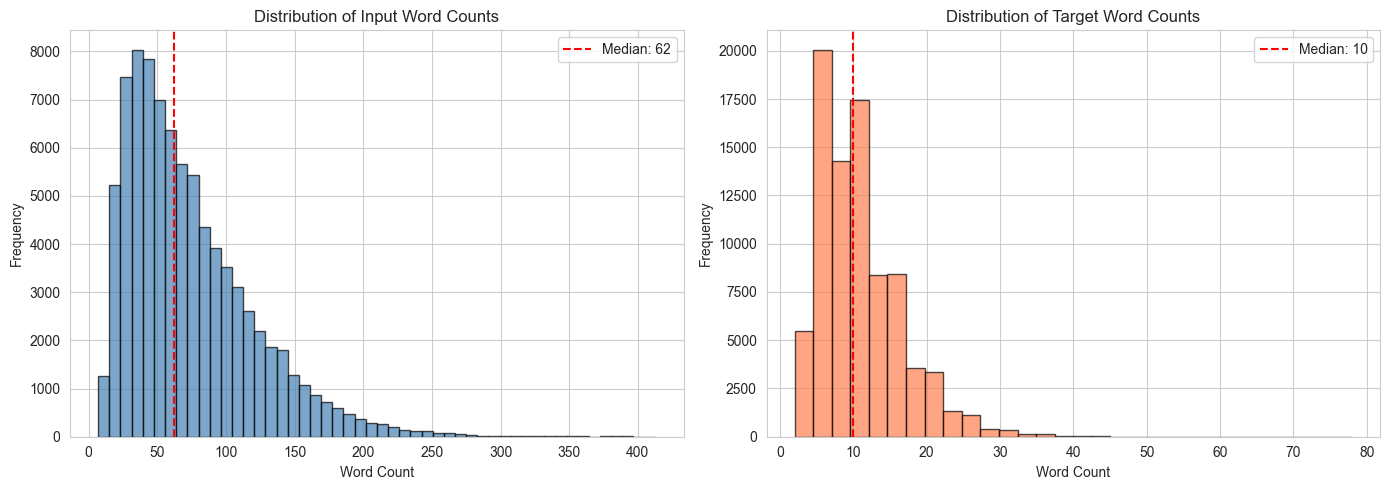

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_df['input_words'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(train_df['input_words'].median(), color='red', linestyle='--', label=f"Median: {train_df['input_words'].median():.0f}")
axes[0].set_title('Distribution of Input Word Counts')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

axes[1].hist(train_df['target_words'], bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].axvline(train_df['target_words'].median(), color='red', linestyle='--', label=f"Median: {train_df['target_words'].median():.0f}")
axes[1].set_title('Distribution of Target Word Counts')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

In [16]:
est_input_tokens = train_df['input_words'] * 1.3
est_target_tokens = train_df['target_words'] * 1.3

print(f"Estimated inputs exceeding 400 tokens: {(est_input_tokens > 400).sum()} ({(est_input_tokens > 400).mean()*100:.1f}%)")
print(f"Estimated targets exceeding 80 tokens: {(est_target_tokens > 80).sum()} ({(est_target_tokens > 80).mean()*100:.1f}%)")

Estimated inputs exceeding 400 tokens: 124 (0.1%)
Estimated targets exceeding 80 tokens: 2 (0.0%)


In [17]:
def display_samples(df, n=5):
    samples = df.sample(n)
    for idx, row in samples.iterrows():
        print("=" * 80)
        print(f"Sample #{idx}")
        print("-" * 40)
        print("CONTEXT:")
        print(row['input'][:300] + "..." if len(row['input']) > 300 else row['input'])
        print("\nSOCRATIC QUESTION:")
        print(row['target'])
        print()

display_samples(train_df, n=3)

Sample #24828
----------------------------------------
CONTEXT:
clarity: But then not making use of the suggested pronoun but instead avoiding gender assigned pronouns altogether still works better from a communication point of view for.me. And maybe I may have just received more information than I needed to know (depending on context) if a preferred pronoun was...

SOCRATIC QUESTION:
If it is a private matter, would that not mean that is not for you to decide which pronoun is valid and which is not?

Sample #65313
----------------------------------------
CONTEXT:
reasons_evidence: Note: Please assume that there is no afterlife when responding to my post. I am not religious. Thank you. ALSO: By "meaningless," I mean "meaningless" to the person who is doing the dying. To the person who is alive and who will then die, life is meaningless. CMV. Assuming there is...

SOCRATIC QUESTION:
Why can things only have meaning if they exist for eternity?

Sample #13286
-----------------------------

In [18]:
from tabulate import tabulate

summary_data = [
    ["Total Training Samples", len(train_df)],
    ["Validation Samples", len(valid_df)],
    ["Test Samples", len(test_df)],
    ["Unique Inputs", train_df['input'].nunique()],
    ["Unique Targets", train_df['target'].nunique()],
    ["Avg Input Length (words)", f"{train_df['input_words'].mean():.1f}"],
    ["Avg Target Length (words)", f"{train_df['target_words'].mean():.1f}"],
    ["Max Input Length (words)", train_df['input_words'].max()],
    ["Max Target Length (words)", train_df['target_words'].max()],
]

print(tabulate(summary_data, headers=["Metric", "Value"], tablefmt="grid"))

+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Total Training Samples    |   84582 |
+---------------------------+---------+
| Validation Samples        |   10573 |
+---------------------------+---------+
| Test Samples              |   10573 |
+---------------------------+---------+
| Unique Inputs             |   81530 |
+---------------------------+---------+
| Unique Targets            |   82108 |
+---------------------------+---------+
| Avg Input Length (words)  |      74 |
+---------------------------+---------+
| Avg Target Length (words) |      11 |
+---------------------------+---------+
| Max Input Length (words)  |     413 |
+---------------------------+---------+
| Max Target Length (words) |      78 |
+---------------------------+---------+


## Key Observations

The training set comprises 84,582 examples across five question types, with `reasons_evidence` (35%) and `clarity` (35%) accounting for the majority. The median input is 62 words and the median question is 10 words; fewer than 0.1% of inputs exceed the 400-token encoder budget, so truncation has negligible impact. The 3,052 duplicate inputs (3.6%) are removed during preprocessing. These statistics are consistent with the description in Ang et al. (2023, §2.2).